# Credit Card Fraud Detection

The credit card fraud detection data comes from [kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). The data is post principal component analysis in order to protect privacy of the credit card users. There are 28 principal components, a time variable, and amount variable, and a binary class variable where a 1 represents a fradualent case and a 0 represents a non-fradualent case.

In [1]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as Knn
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
import xgboost as xgb

#Visualization and utility
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.colors as cl
%matplotlib inline

#Criterion
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report , confusion_matrix

#Model Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, StratifiedKFold

#Imbalanced Learn over_sampling and preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler,StandardScaler


In [2]:
data = pd.read_csv('/Users/clayolsen1/ML_folder/anomly_detection_ML/creditcard.csv')
print(data.head())
#data.describe()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## Exploratory Analysis

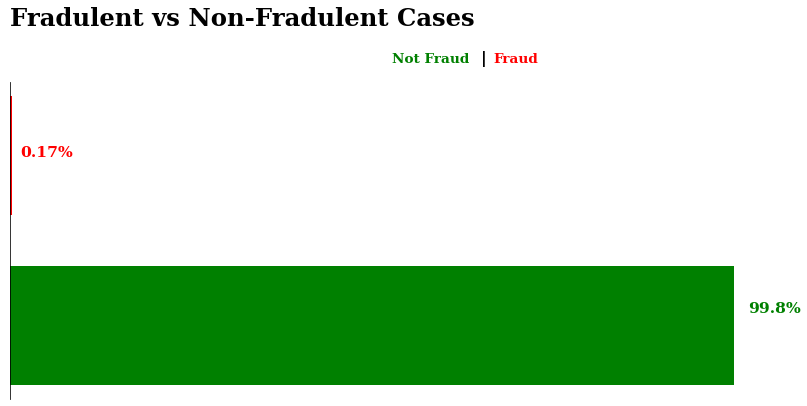

In [3]:
%%capture --no-display

# color palette for visualizations
colors = ['black','blue','green','red','orange']
palette = sns.color_palette( palette = colors)
x = pd.DataFrame(data.groupby(['Class'])['Class'].count())

# plot
fig, ax = plt.subplots(figsize = (14,6), dpi=70 )
ax.barh([0], x.Class[0], height = 0.7, color = colors[2])
plt.text(290000,0.08, '99.8%',{'fontname':'Serif','weight':'bold' ,'size':'16','color': colors[2]})
ax.barh([1], x.Class[1], height = 0.7, color = colors[3])
plt.text(3900,1, '0.17%',{'fontname':'Serif', 'weight':'bold','size':'16','color':colors[3]})

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.text(-150,1.77, 'Fradulent vs Non-Fradulent Cases' ,{'fontname': 'Serif', 'Size': '25','weight':'bold', 'color':colors[0]})
plt.text(150000,1.55, 'Not Fraud ', {'fontname': 'Serif','weight':'bold','Size': '14','weight':'bold','style':'normal', 'color':colors[2]})
plt.text(185000,1.55, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
plt.text(190000,1.55, 'Fraud', {'fontname': 'Serif','weight':'bold', 'Size': '14','style':'normal', 'weight':'bold','color':colors[3]})
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<AxesSubplot:title={'center':'Distribution of time according to classes'}, xlabel='Time', ylabel='Density'>

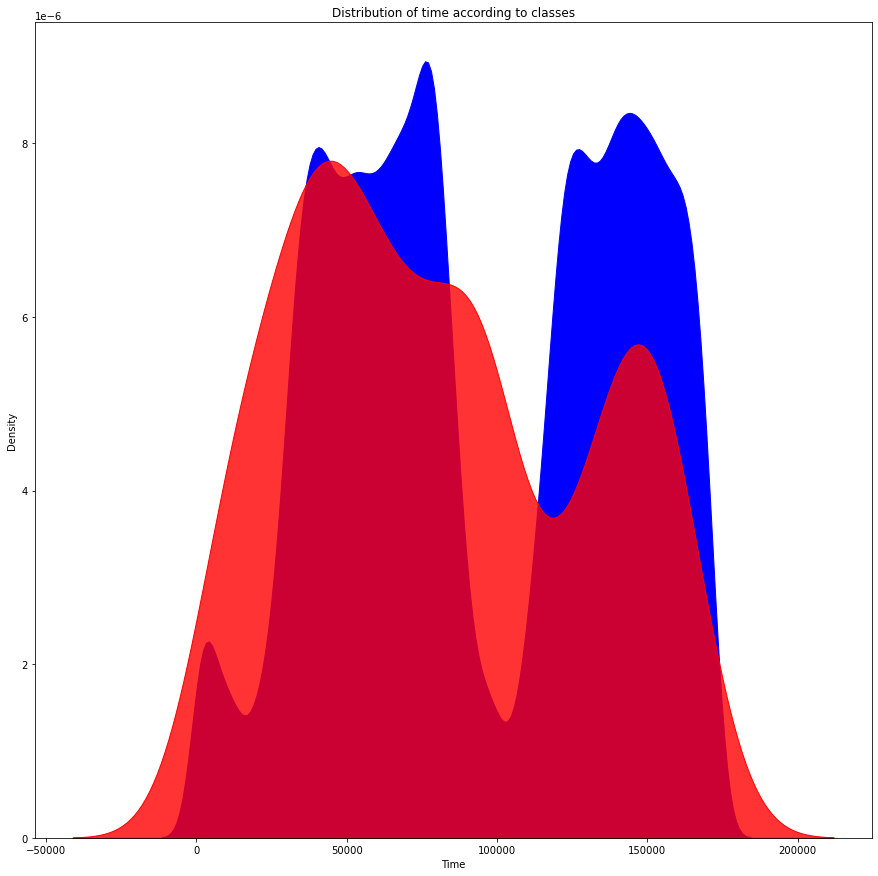

In [4]:
%%capture --no-display
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title("Distribution of time according to classes")
sns.kdeplot(data[data['Class']==0]['Time'],ax=ax,color = colors[1],legend=True,shade=True,alpha=1)
sns.kdeplot(data[data['Class']==1]['Time'],ax=ax,color = colors[3],shade=True,legend=True,alpha=0.8)


<AxesSubplot:>

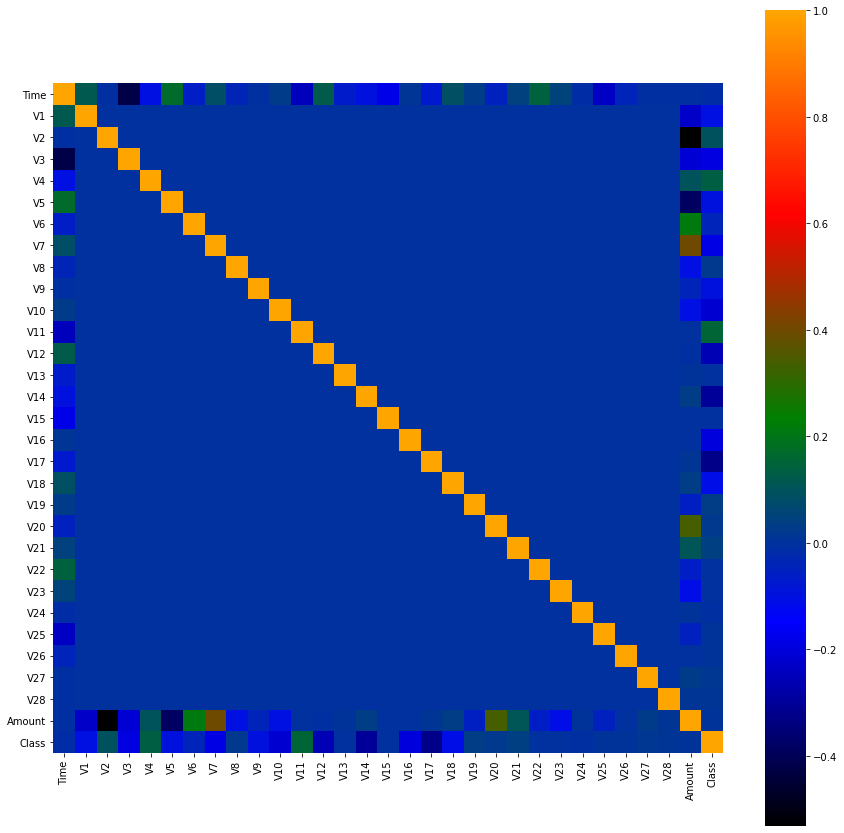

In [5]:
fig,ax = plt.subplots(1,1,figsize=(15,15))

CORR = data.corr()
sns.heatmap(CORR,cmap=cl.LinearSegmentedColormap.from_list("",colors),square=True , annot_kws={'size': 10}, ax=ax)

Text(0.5, 1.0, 'BoxPlot for Amount')

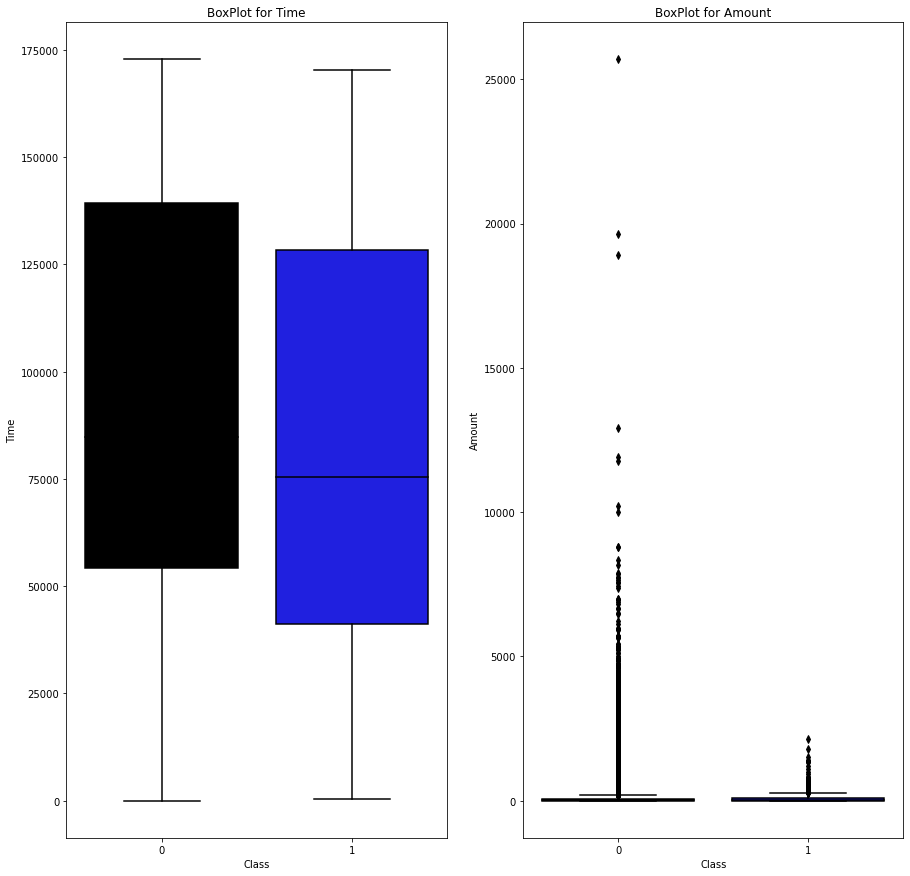

In [6]:
fig,axes = plt.subplots(1,2,figsize=(15,15))

sns.boxplot(x = data['Class'],y = data["Time"],ax=axes[0],palette=palette)
axes[0].set_title("BoxPlot for Time")
sns.boxplot(x = data['Class'],y = data.Amount,ax=axes[1],palette=palette)
axes[1].set_title("BoxPlot for Amount")

# Scaling/Normalizing Data

We will apply a RobustScaler for the Amount and Time features as the other features are already PCA transformed.

In [7]:
rbst = RobustScaler()
# Using RobustScaler 
data['Amount'] = rbst.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time'] = rbst.fit_transform(data['Time'].values.reshape(-1,1))
X = data.drop('Class',axis=1)
Y = data.Class.values
trainX,testX,trainY,testY = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)

# Random Forest Classifier

In [8]:
clf = RandomForestClassifier(n_estimators=100,n_jobs=4,verbose=False)
clf.fit(trainX,trainY)
#Confusion Matrix of results
y_pred = clf.predict(testX)

0.892839557038347
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



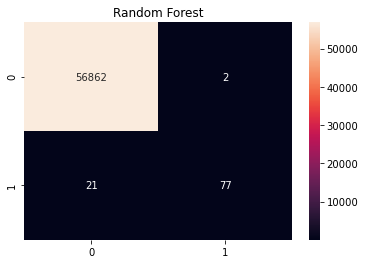

In [9]:
sns.heatmap(confusion_matrix(testY,y_pred),annot=True,fmt='0.0f').set_title('Random Forest')
results = classification_report(testY,y_pred)
print(roc_auc_score(testY, y_pred))
print(classification_report(testY,y_pred))
#print(np.bincount(y_pred))

# Over Sample to minimize recall rather than accuracy

In [10]:
oversample = SMOTE(random_state=42)
X_smote,Y_smote = oversample.fit_resample(trainX,trainY)

<AxesSubplot:title={'center':'SMOTE Data'}, xlabel='Class', ylabel='count'>

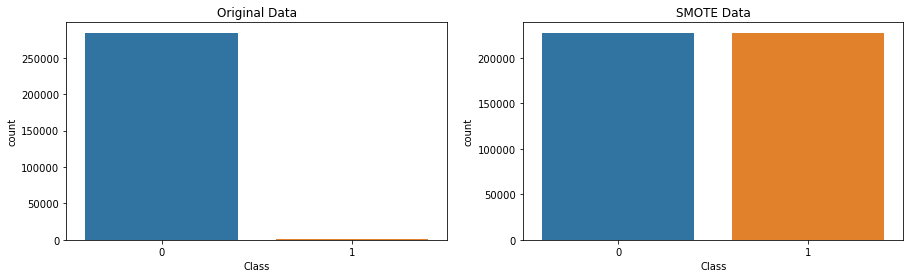

In [11]:
%%capture --no-display
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].set_title('Original Data')
barplot_data1 = pd.DataFrame(data['Class'], columns=['Class'])
sns.countplot('Class', data = barplot_data1, ax = axes[0])

axes[1].set_title('SMOTE Data')
barplot_data = pd.DataFrame(Y_smote, columns=['Class'])
sns.countplot('Class', data = barplot_data, ax = axes[1])

# Random Forest with Smote data

In [12]:
#Model after oversampling
clf2 = RandomForestClassifier(n_estimators=100,n_jobs=4,verbose=False)
clf2.fit(X_smote,Y_smote)
y_pred_smote = clf2.predict(testX)

0.9182882107541948
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



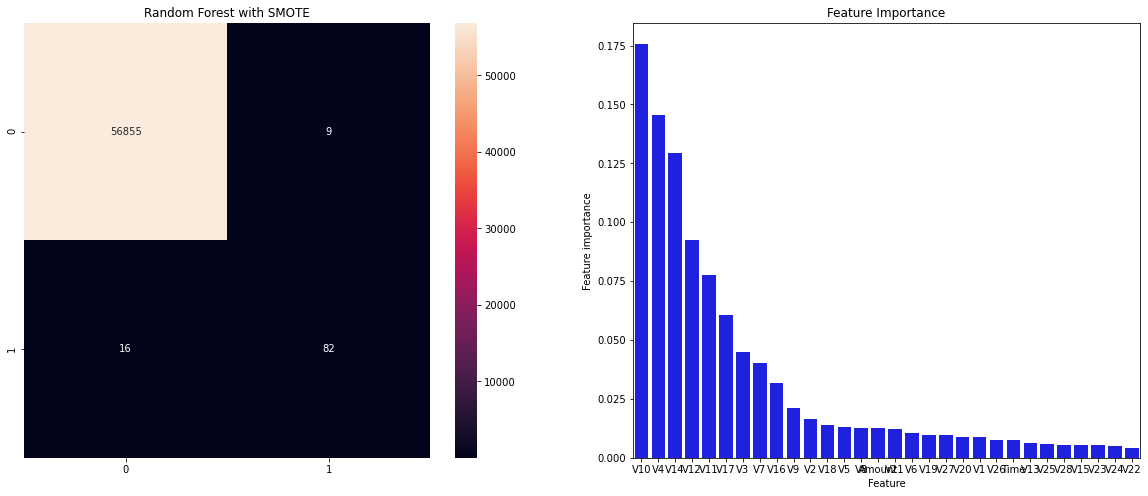

In [13]:
#Plot results
fig, axes = plt.subplots(1,2,figsize=(20,8))
axes[0].set_title("Random Forest with SMOTE")
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')
sns.heatmap(confusion_matrix(testY, y_pred_smote),annot=True, fmt='0.0f', ax=axes[0])

predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19','V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Amount']
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp,color=colors[1],ax=axes[1])
axes[1].set_title("Feature Importance")

print(roc_auc_score(testY, y_pred_smote))
print(classification_report(testY,y_pred_smote))


# KNN Classification

In [14]:
model = Knn()
model.fit(X_smote,Y_smote)
y_pred_NN = model.predict(testX)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.48      0.88      0.62        98

    accuracy                           1.00     56962
   macro avg       0.74      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962

0.9379401838112846


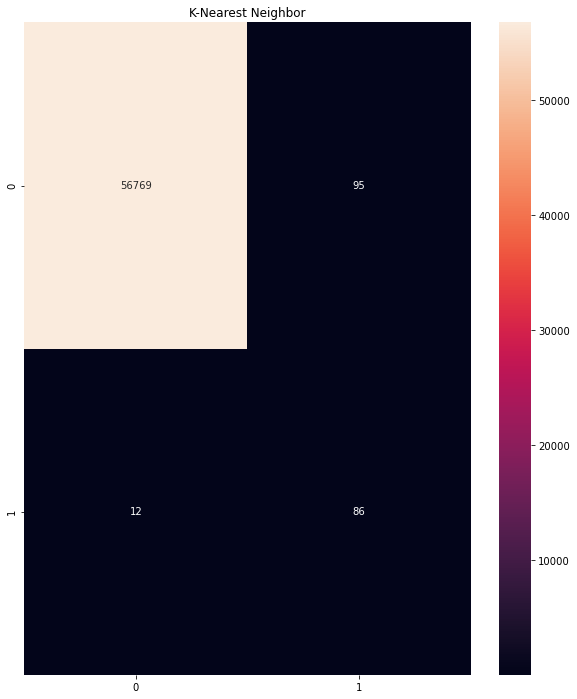

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,12))
ax.set_title("K-Nearest Neighbor")
sns.heatmap(confusion_matrix(testY,y_pred_NN), annot=True,  fmt='0.0f')

print(classification_report(testY,y_pred_NN))
print(roc_auc_score(testY, y_pred_NN))

# Adaboost with SMOTE Data

In [16]:
adamodel = AdaBoostClassifier(random_state=42,  algorithm='SAMME.R',learning_rate=0.8,)
adamodel.fit(X_smote,Y_smote)
y_pred_ada = adamodel.predict(testX)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962

0.9528285533403007


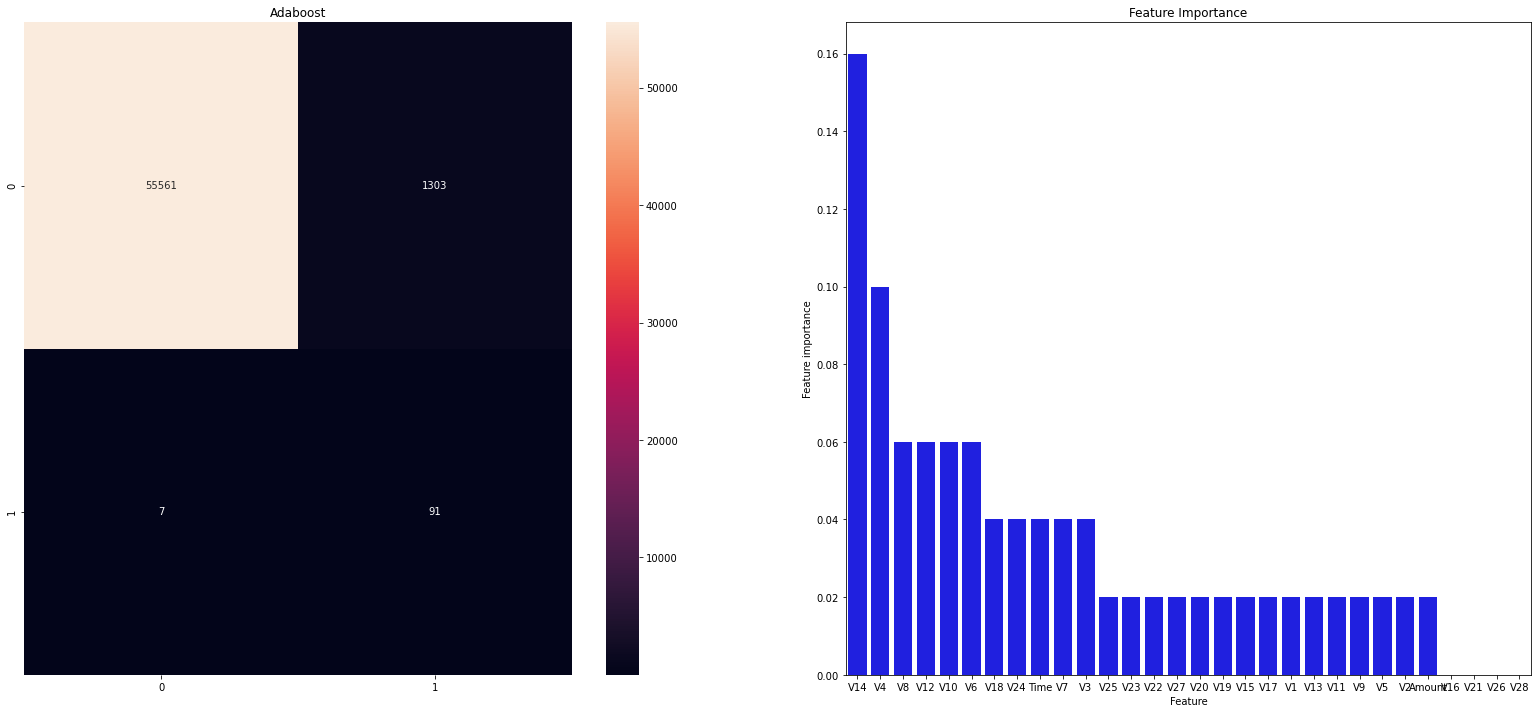

In [17]:
fig, axes = plt.subplots(1,2,figsize=(27,12))
axes[0].set_title("Adaboost")
sns.heatmap(confusion_matrix(testY,y_pred_ada),annot=True,fmt='0.0f',ax=axes[0])

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': adamodel.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending=False)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp, color=colors[1], ax=axes[1])
axes[1].set_title("Feature Importance")

print(classification_report(testY,y_pred_ada))
print(roc_auc_score(testY,y_pred_ada))

# XGBoost

In [18]:
model_xgb = xgb.XGBClassifier(silent=True,max_depth=2,eval_metric='auc')
model_xgb.fit(X_smote,Y_smote)
y_pred_xgb = model_xgb.predict(testX)

/Users/clayolsen1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:16:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.14      0.91      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.95      0.62     56962
weighted avg       1.00      0.99      0.99     56962

0.9491576033902588


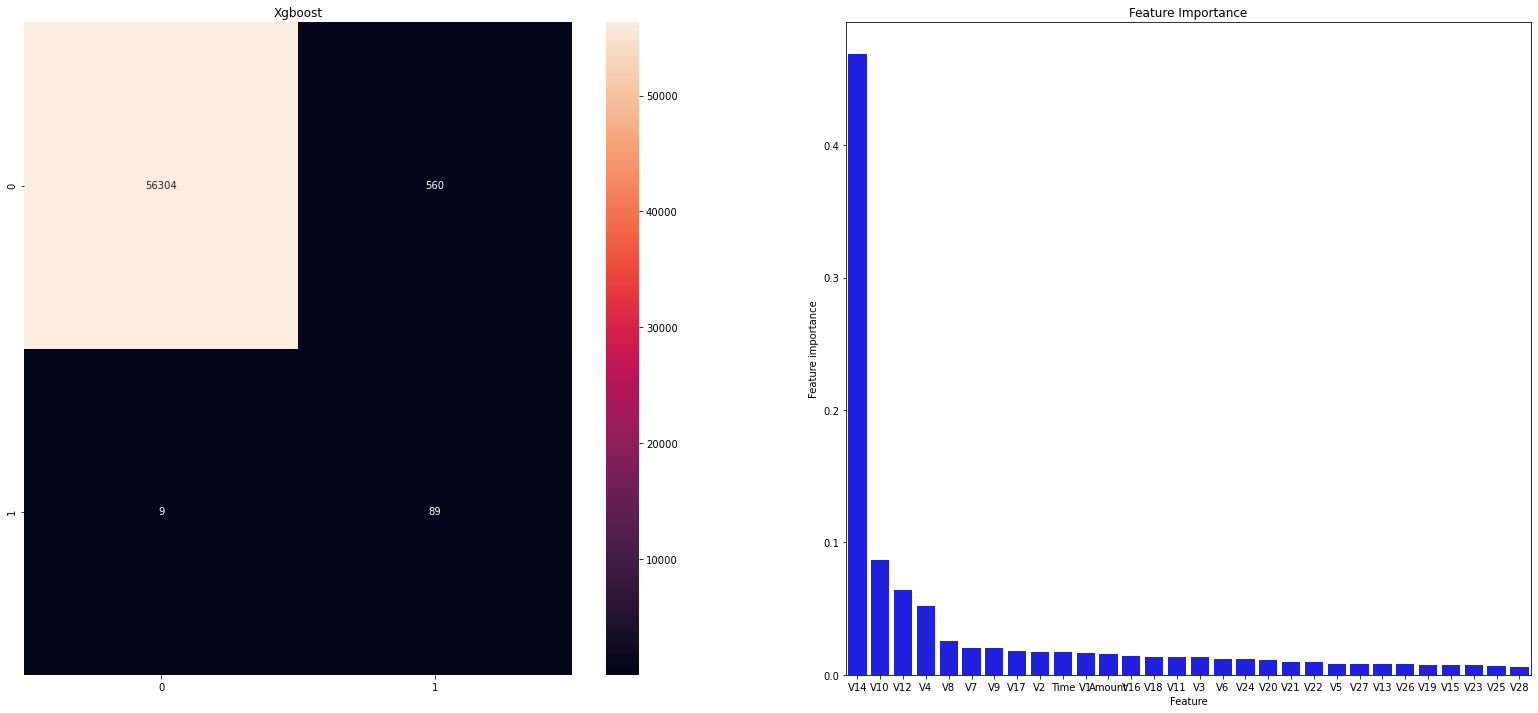

In [19]:
fig, axes = plt.subplots(1,2,figsize=(27,12))
axes[0].set_title("Xgboost")
sns.heatmap(confusion_matrix(testY,y_pred_xgb),annot=True,fmt='0.0f',ax=axes[0])

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model_xgb.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp,color=colors[1],ax=axes[1])
axes[1].set_title("Feature Importance")
print(classification_report(testY,y_pred_xgb))
print(roc_auc_score(testY, y_pred_xgb))

# Feature Selection using XGboost


In [20]:
slm = SelectFromModel(model_xgb,threshold=0.02)
X_train_xgb = slm.fit_transform(X_smote,Y_smote)
# Because we need to select the same features as train dataset
test_xgb = np.array(testX[testX.columns[slm.get_support()]])
# Prepare the train and test datasets
dtrain = xgb.DMatrix(pd.DataFrame(X_train_xgb),Y_smote )
dtest = xgb.DMatrix(pd.DataFrame(test_xgb), testY)

#What to monitor (in this case, **train** and **test**)
watchlist = [(dtrain, 'train'), (dtest, 'test')]

/Users/clayolsen1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [21]:
params = {}
params['objective'] = 'binary:logistic'
params['silent'] = True
params['max_depth'] = 2
params['eval_metric'] = 'auc'
params['random_state'] = 42
model = xgb.train(params,dtrain,200,watchlist)

[14:17:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.95309	test-auc:0.95119
[1]	train-auc:0.96790	test-auc:0.95710
[2]	train-auc:0.97264	test-auc:0.96128
[3]	train-auc:0.97645	test-auc:0.96020
[4]	train-auc:0.97855	test-auc:0.96952
[5]	train-auc:0.98122	test-auc:0.97462
[6]	train-auc:0.98200	test-auc:0.97607
[7]	train-auc:0.98437	test-auc:0.97651
[8]	train-auc:0.98507	test-auc:0.97811
[9]	train-auc:0.98659	test-auc:0.98137
[10]	train-auc:0.98673	test-auc:0.98126
[11]	train-auc:0.98797	test-auc:0.98151
[12]	train-auc:0.98849	test-auc:0.98247
[13]	train-auc:0.98909	test-auc:0.98474
[14]	train-auc:

<AxesSubplot:title={'center':'Feature importance '}, xlabel='F score', ylabel='Features'>

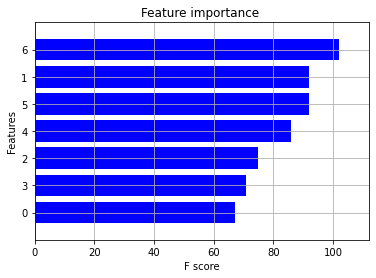

In [22]:
y_pred = model.predict(dtest)
xgb.plot_importance(model, height=0.8, title="Feature importance ",color=colors[1],show_values=False)

# Precision Recall

Random Forest 0.8367346938775511
K-Nearest Neighbor 0.8775510204081632
Adaboost 0.9285714285714286
XGBoost 0.9081632653061225
Random Forest 0.7542616021781151
K-Nearest Neighbor 0.41716861015865014
Adaboost 0.06073981864221495
XGBoost 0.12469810887183227


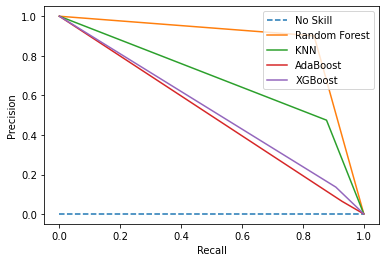

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, average_precision_score

recall_RF = recall_score(testY, y_pred_smote)
recall_KNN = recall_score(testY, y_pred_NN)
recall_ada = recall_score(testY, y_pred_ada)
recall_xgb = recall_score(testY, y_pred_xgb)
print('Random Forest', recall_RF)
print('K-Nearest Neighbor', recall_KNN)
print('Adaboost', recall_ada)
print('XGBoost', recall_xgb)

average_precision_RF = average_precision_score(testY, y_pred_smote)
average_precision_KNN = average_precision_score(testY, y_pred_NN)
average_precision_ada = average_precision_score(testY, y_pred_ada)
average_precision_xgb = average_precision_score(testY, y_pred_xgb)
print('Random Forest', average_precision_RF)
print('K-Nearest Neighbor', average_precision_KNN)
print('Adaboost', average_precision_ada)
print('XGBoost', average_precision_xgb)


no_skill = len(testY[testY==1]) / len(testY)
precision_RF, recall_RF, _ = precision_recall_curve(testY, y_pred_smote)
precision_KNN, recall_KNN, _ = precision_recall_curve(testY, y_pred_NN)
precision_ada, recall_ada, _ = precision_recall_curve(testY, y_pred_ada)
precision_xgb, recall_xgb, _ = precision_recall_curve(testY, y_pred_xgb)


plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.plot(recall_RF, precision_RF, label='Random Forest')
plt.plot(recall_KNN, precision_KNN, label='KNN')
plt.plot(recall_ada, precision_ada, label='AdaBoost')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


Random Forest 0.9182882107541948
K-Nearest Neighbor 0.9379401838112846
Adaboost 0.9528285533403007
XGBoost 0.9491576033902588


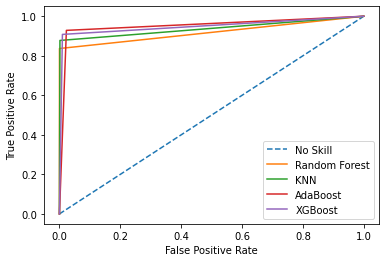

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score_RF = roc_auc_score(testY, y_pred_smote)
roc_auc_score_KNN = roc_auc_score(testY, y_pred_NN)
roc_auc_score_ada = roc_auc_score(testY, y_pred_ada)
roc_auc_score_xgb = roc_auc_score(testY, y_pred_xgb)
print('Random Forest', roc_auc_score_RF)
print('K-Nearest Neighbor', roc_auc_score_KNN)
print('Adaboost', roc_auc_score_ada)
print('XGBoost', roc_auc_score_xgb)


tpr_RF, fpr_RF, _ = roc_curve(testY, y_pred_smote)
tpr_KNN, fpr_KNN, _ = roc_curve(testY, y_pred_NN)
tpr_ada, fpr_ada, _ = roc_curve(testY, y_pred_ada)
tpr_xgb, fpr_xgb, _ = roc_curve(testY, y_pred_xgb)


plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.plot(tpr_RF, fpr_RF, label='Random Forest')
plt.plot(tpr_KNN, fpr_KNN, label='KNN')
plt.plot(tpr_ada, fpr_ada, label='AdaBoost')
plt.plot(tpr_xgb, fpr_xgb, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

